In [2]:
import collections
import heapq
import matplotlib.pyplot as plt
import numpy as np
import os

from matplotlib import offsetbox
from scipy.sparse import csr_matrix
from sklearn import cluster, datasets, decomposition, ensemble, lda, manifold, random_projection
from sklearn.decomposition import TruncatedSVD
from time import time

%matplotlib inline

In [3]:
def sparse_where(sparse_matrix, num):
    """
    np.where() for a sparse matrix. Returns a set of indices.
    """
    return set(np.where(sparse_matrix[num,:].toarray())[1].tolist())

In [4]:
# Skip parts that take a long time.
SKIP_LONG_PARTS = True

# Create a dense representation of the data.
CREATE_DENSE_ARRAY = False

NUM_SPEECHES = 2740

NUM_DEBATES = 38

In [5]:
WORD_INDEX = 0
WORD_FREQ = 1

# Used for building the sparse data matrix.
sparse_indptr = [0]
sparse_indices = []
sparse_data = []
vocabulary = {}

inverted_index = collections.defaultdict(set)

dense_data = None

print 'Reading data.'
for line_num, line in enumerate(open('speech_vectors.csv')):
    new_row = [(idx,float(freq)) for idx, freq in enumerate(line.strip().split(',')) if float(freq) > 0.0]
    for i,f in new_row:
        sparse_indices.append(i)
        sparse_data.append(f)
        inverted_index[i].add(line_num)
    sparse_indptr.append(len(sparse_indices))
    
    if line_num % 150 == 0:
        print 100.0 * line_num / 2740, '%'
print 100.0 * line_num / 2740, '%'

sparse_data = csr_matrix((sparse_data, sparse_indices, sparse_indptr), dtype=float)
print 'Done reading data.'

print sparse_data.shape

Reading data.
0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
99.9635036496 %
Done reading data.
(2740, 50000)


In [6]:
speech_graph = []
for line in open('speech_graph.csv'):
    speech_graph.append( [float(i) for i in line.strip().split(',')] )
    
print len(speech_graph)
sparse_speech_graph = csr_matrix(speech_graph)


2740


## SVM Classification

In [7]:
from sklearn import svm, grid_search
from sklearn.decomposition import PCA, SparsePCA
from scipy import sparse as sp

# run PCA on data
truncated_svd = TruncatedSVD(n_components=10)
reduced_data = truncated_svd.fit_transform(sp.hstack((np.array(speech_graph), sparse_data[:, :25000])))

# form the training data
X = reduced_data[[2, 13, 18, 24, 1, 3, 27, 177], :]
y = [0 for i in range(4)] + [1 for i in range(4)]

# # run PCA on data
# pca = PCA(n_components=50)
# denseX = X.toarray()
# reducedX = pca.fit(denseX).transform(denseX)
# X = csr_matrix(reducedX)

# fit SVM, searching over paramaters
parameters = {'kernel':('linear', 'rbf'), 'C':np.arange(1, 10, 0.5)}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
a = clf.fit(X, y)
print a
print clf

# make predictions
predictions = []
ones = 0

for i in range(len(reduced_data)):
    prediction = clf.predict(reduced_data[i])[0]
    if prediction == 1:
        ones += 1
    predictions += [prediction]

clf = grid_search.GridSearchCV(svr, parameters)

# print predictions
print float(ones)/len(predictions)

GridSearchCV(cv=None,
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)
GridSearchCV(cv=None,
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. 

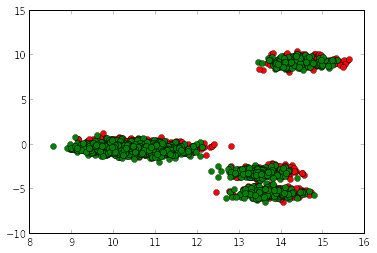

In [8]:
for_points = []
against_points = []

for i, label in enumerate(predictions):
    if(label == 1):
        for_points += [reduced_data[i]]
    else:
        against_points += [reduced_data[i]]

plt.plot([p[0] for p in for_points], [p[1] for p in for_points], 'ro')
plt.plot([p[0] for p in against_points], [p[1] for p in against_points], 'go')


In [14]:
good_preds = np.loadtxt(open('preds_laplacian1.csv'),delimiter=",",skiprows=1)

# score = 0
# for i, pred in enumerate(good_preds):
#     if pred == predictions[i]:
#         score += 1
# print 'score' + str(score/2740.0)
    
print (2740-sum(np.logical_xor(predictions, good_preds[:, 1])))/2740.0

with open('svm_pred.csv', 'w') as output_file:
    output_file.write('Id,Prediction\n')
    for i, p in enumerate(predictions):
        output_file.write(str(i) + ', ' + str(p) + '\n')
        

0.99197080292


In [15]:
speech_graph_copy = csr_matrix(sparse_speech_graph)

speech_row_sums = {i: len(sparse_where(sparse_speech_graph, i)) for i in range(NUM_SPEECHES)}

print speech_graph_copy[0, 0]

# Create affinity matrix.
print 'Creating affinity matrix.'
for row in range(NUM_SPEECHES):
    row_indices = sparse_where(sparse_speech_graph, row)
    for index in row_indices:
        if abs(speech_row_sums[index] - speech_row_sums[row]) <= 50.8851648322 :
            speech_graph_copy[row, index] = 0.0
    if row % 150 == 0:
        print row * 100.0 / NUM_SPEECHES, '%'

print 'Done'


0.0
Creating affinity matrix.
0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
Done


In [ ]:
from sklearn import svm, grid_search
from sklearn.decomposition import PCA, SparsePCA
from scipy import sparse as sp

# run PCA on data
truncated_svd = TruncatedSVD(n_components=10)
reduced_data = truncated_svd.fit_transform(sp.hstack((speech_graph_copy, sparse_data[:, :25000])))

# form the training data
X = reduced_data[[2, 13, 18, 24, 1, 3, 27, 177], :]
y = [0 for i in range(4)] + [1 for i in range(4)]

# # run PCA on data
# pca = PCA(n_components=50)
# denseX = X.toarray()
# reducedX = pca.fit(denseX).transform(denseX)
# X = csr_matrix(reducedX)

# fit SVM, searching over paramaters
parameters = {'kernel':('linear', 'rbf'), 'C':[np.arange(1, 10, 0.5)]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
a = clf.fit(X, y)
print clf

# make predictions
predictions = []
ones = 0

for i in range(len(reduced_data)):
    prediction = clf.predict(reduced_data[i])[0]
    if prediction == 1:
        ones += 1
    predictions += [prediction]

clf = grid_search.GridSearchCV(svr, parameters)

# print predictions
print float(ones)/len(predictions)

In [ ]:
good_preds = np.loadtxt(open('preds_laplacian1.csv'),delimiter=",",skiprows=1)
# score = 0
# for i, pred in enumerate(good_preds):
#     if pred == predictions[i]:
#         score += 1
# print 'score' + str(score/2740.0)
    
print (2740-sum(np.logical_xor(predictions, good_preds[:, 1])))/2740.0